# Interpretation

In this notebook we will interpret important features using different methods and visualize the most important, using techniques such as Random Forest and SHAP values. We will also interpret the results from our threshold analysis.

In [ ]:
import pandas as pd
import shap
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import csv
from sklearn.linear_model import Ridge
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt

# user defined methods
import sys
sys.path.append('../utils')

from modeling import split_data
from threshold_analysis import read_cheap_features, set_threshold, split_data, oversample_data, find_threshold, feature_importance

## Interpretating Cheap Features using SHAP Values

In [5]:
df = pd.read_csv('../../data/processed/cheap_features/Ant_Lif.csv')
df

,hip,neck20,coffee15,tea15,soda15,evsmok15,smknow15,asa15,smokstat_s1,bmi_s1,weight,waist,height,weight20,nsrrid,ahi_c0h4
0,99.0,38.3,2.0,0.0,1.0,1.0,0.0,1.0,2.0,21.777553,65.0,86.0,178.0,69.0,200001.0,1.278296
1,122.0,40.5,0.0,0.0,0.0,0.0,1.0,1.0,0.0,32.950680,93.0,107.0,168.0,93.0,200002.0,14.505495
2,95.0,39.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,24.114150,51.0,82.0,145.0,50.7,200003.0,4.184100
3,99.0,39.2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,20.185185,64.0,85.0,180.0,65.4,200004.0,0.199336
4,97.0,32.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,23.309053,56.0,76.0,155.0,56.0,200005.0,2.756757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5799,95.0,41.5,2.0,0.0,0.0,0.0,1.0,0.0,0.0,25.693134,70.5,99.0,166.0,70.8,205800.0,10.743551
5800,99.0,34.9,6.0,0.0,1.0,1.0,1.0,1.0,1.0,26.730372,83.6,99.0,176.0,82.8,205801.0,13.198483
5801,101.0,37.0,10.0,0.0,1.0,0.0,1.0,0.0,0.0,24.228571,75.0,91.0,175.0,74.2,205802.0,2.019231
5802,98.0,39.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,25.374483,76.8,93.0,176.0,78.6,205803.0,1.186650


In [6]:
# the column names of the cheap features
feature_dict = {'smokstat_s1':'smoke status', 
                'smknow15':'smoke cigarettes now?', 
                'evsmok15':'ever smoked?', 
                'height':'height', 
                'weight20':'weight at blood pressure measurement', 
                'neck20':'neck circumference', 
                'bmi_s1':'bmi', 
                'weight':'weight', 
                'waist':'waist circumference', 
                'tea15':'Number of cups of tea per day',
                'soda15':'Number of cups of soda per day', 
                'nsrrid':'identifier link', 
                'asa15':'any aspirin in last 2 weeks', 
                'hip':'hip cicumference', 
                'coffee15':'number of cups of coffee per day'}

In [7]:
df.rename(columns=feature_dict, inplace=True)
target = 'ahi_c0h4'
features = df.columns.tolist()
features.remove(target)
df

,hip cicumference,neck circumference,number of cups of coffee per day,Number of cups of tea per day,Number of cups of soda per day,ever smoked?,smoke cigarettes now?,any aspirin in last 2 weeks,smoke status,bmi,weight,waist circumference,height,weight at blood pressure measurement,identifier link,ahi_c0h4
0,99.0,38.3,2.0,0.0,1.0,1.0,0.0,1.0,2.0,21.777553,65.0,86.0,178.0,69.0,200001.0,1.278296
1,122.0,40.5,0.0,0.0,0.0,0.0,1.0,1.0,0.0,32.950680,93.0,107.0,168.0,93.0,200002.0,14.505495
2,95.0,39.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,24.114150,51.0,82.0,145.0,50.7,200003.0,4.184100
3,99.0,39.2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,20.185185,64.0,85.0,180.0,65.4,200004.0,0.199336
4,97.0,32.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,23.309053,56.0,76.0,155.0,56.0,200005.0,2.756757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5799,95.0,41.5,2.0,0.0,0.0,0.0,1.0,0.0,0.0,25.693134,70.5,99.0,166.0,70.8,205800.0,10.743551
5800,99.0,34.9,6.0,0.0,1.0,1.0,1.0,1.0,1.0,26.730372,83.6,99.0,176.0,82.8,205801.0,13.198483
5801,101.0,37.0,10.0,0.0,1.0,0.0,1.0,0.0,0.0,24.228571,75.0,91.0,175.0,74.2,205802.0,2.019231
5802,98.0,39.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,25.374483,76.8,93.0,176.0,78.6,205803.0,1.186650


Do SHAP on test set

In [8]:
# Split data
X_train, X_test, y_train, y_test, X_val, y_val = split_data(df, features, target)

model = Ridge(alpha=4.434528937795567, random_state=1, solver='sparse_cg')
model.fit(X_train, y_train)

#create an explainer
explainer = shap.LinearExplainer(model, X_train)
shap_values_test = explainer.shap_values(X_test)

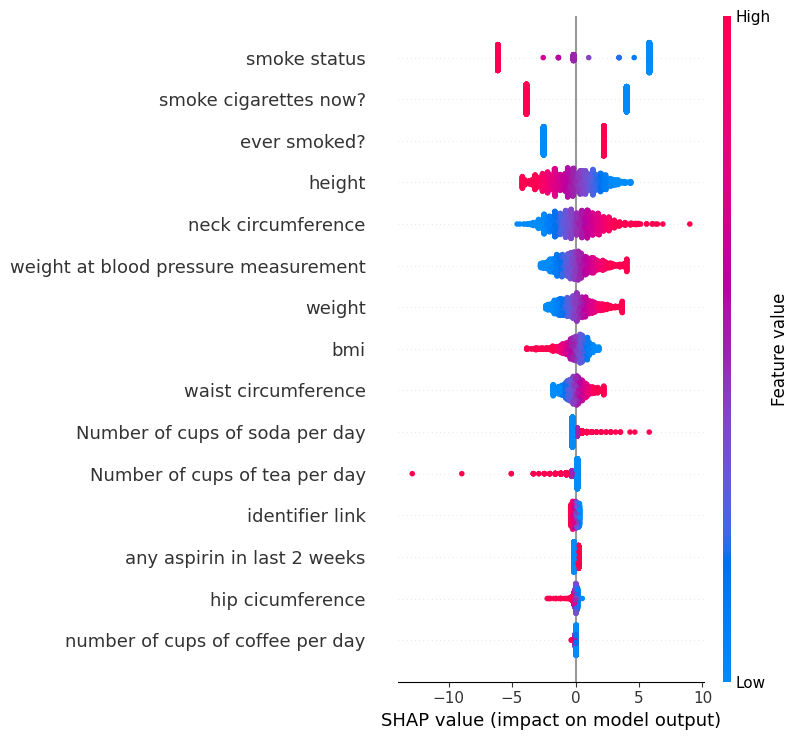

In [9]:
#It plots all the SHAP values for each feature for each sample. It shows both the distribution of the impacts each feature has on the model output and the direction of the impact.
shap.summary_plot(shap_values_test, X_test, show=False)
plt.savefig('../../visualizations/cheap_feature_importance_test.jpg')

In [10]:
plt.savefig('../../visualizations/cheap_feature_importance_test.png')

<Figure size 640x480 with 0 Axes>

On training set

In [11]:
X_train, X_test, y_train, y_test, X_val, y_val = split_data(df, features, target)

model = Ridge(alpha=4.434528937795567, random_state=1, solver='sparse_cg')
model.fit(X_train, y_train)

#create an explainer
explainer = shap.LinearExplainer(model, X_train)
shap_values_train = explainer.shap_values(X_train)

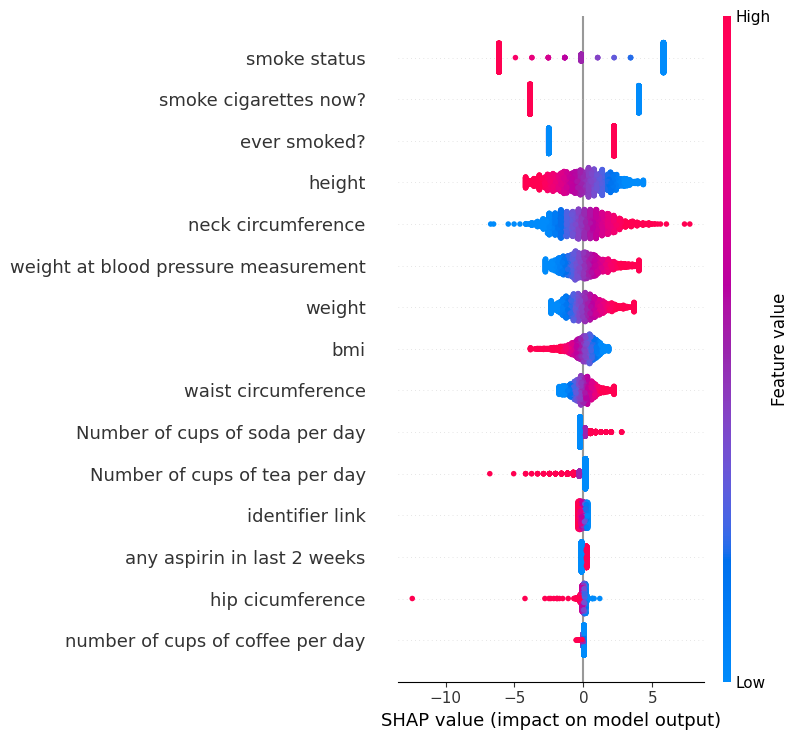

In [12]:
shap.summary_plot(shap_values_train, X_train, show=False)
plt.savefig('../../visualizations/cheap_feature_importance_train.jpg')

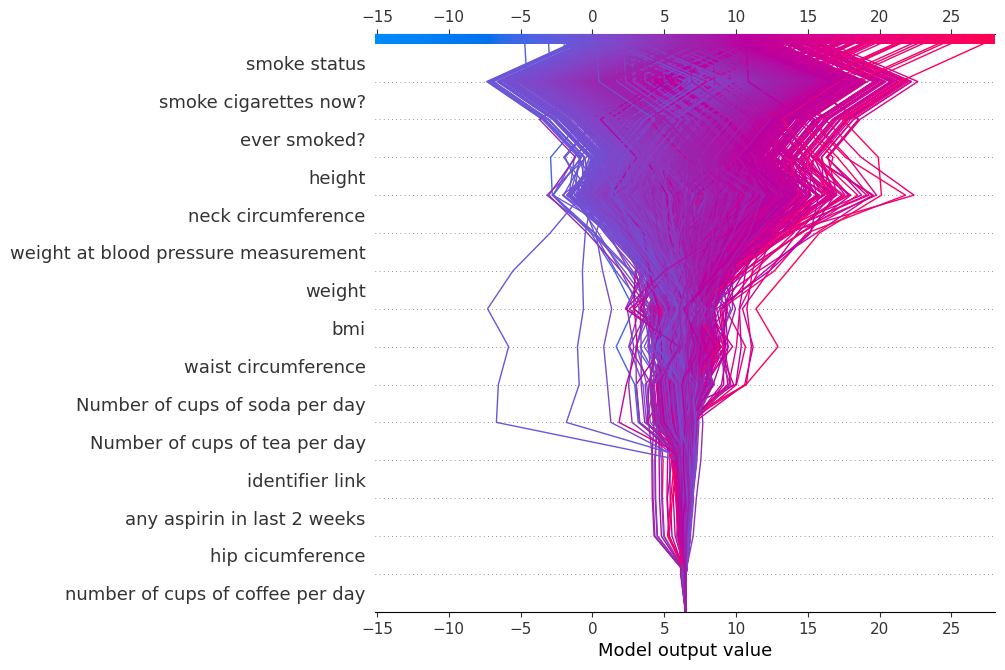

In [13]:
# It plots the cumulative SHAP values for each feature to show how the final prediction is formed from the base value.
shap.decision_plot(explainer.expected_value, shap_values_test, X_test)

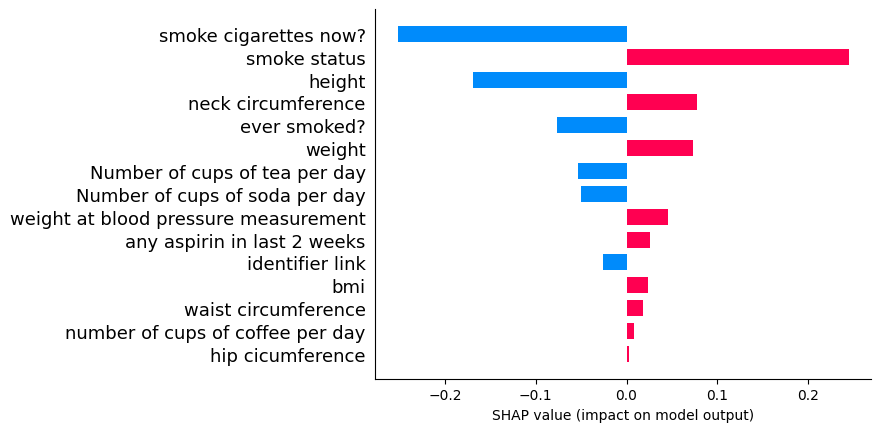

In [14]:
#It shows the average SHAP value (magnitude of impact) for each feature across all samples.
shap_values_sum = np.mean(shap_values_test, axis=0)
shap.bar_plot(shap_values_sum, max_display=20, feature_names=features)

## Threshold Analysis Interpretation

In [ ]:
output = read_cheap_features('../../data/processed/cheap_features/Ant_Dem_Lif.csv', "hf15", pd)
output

### Dataset: ahi_c0h4 = 1

In [ ]:
set_threshold(output)

In [ ]:
best_dataset, best_model, results = find_threshold('../../data/processed/threshold2/')

In [ ]:
best_dataset, best_model

Get feature importance

In [ ]:
feature_importances = feature_importance('ahic0h4_threshold_2.csv', RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=90,
                        min_samples_split=5, n_estimators=292, random_state=1))

In [ ]:
plt.figure(figsize=(12, 8))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

In [ ]:
path = '../../data/processed/threshold2/' + best_dataset
df = pd.read_csv(path)
df['hf15'] = df['hf15'].astype(int)
features = df.columns.tolist()
features.remove('hf15')
X, y = oversample_data(df, features, 'hf15')
data = pd.concat([X, y], axis=1)

X_train, X_test, y_train, y_test, X_val, y_val = split_data(data, features, 'hf15')
model = RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=90,
                        min_samples_split=5, n_estimators=292, random_state=1)
model.fit(X_train, y_train)
explainer = shap.TreeExplainer(model, X_test)
shap_values = explainer(X_test, check_additivity=False)


In [ ]:
shap_values.shape

In [ ]:
shap.summary_plot(shap_values[:, :, 1], X_test)

In [ ]:
csv_file = '../../models/threshold/all_results/model_results.csv'

# Field names (column headers)
field_names = ['File', 'Model', 'F1 Test', 'F1 Validation', 'Confusion Matrix', 'False Negative']

# Writing to csv file
with open(csv_file, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=field_names)

    # Write the headers
    writer.writeheader()

    # Write the data rows
    for result in results:
        writer.writerow(result)